<a href="https://colab.research.google.com/github/rrfsantos/Projeto-Redes-Neurais-OCT-Images/blob/main/Transfer_learning_Xception.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Convolutional Neural Network, Data Augmentation, Transfer Learning
### Task: Automated methods to detect and classify human diseases from medical images.
### Dataset:  Labeled Optical Coherence Tomography (OCT) Images for Classification - Kermany, Daniel; Zhang, Kang; Goldbaum, Michael (2018), “Labeled Optical Coherence Tomography (OCT) and Chest X-Ray Images for Classification”, Mendeley Data, v2 http://dx.doi.org/10.17632/rscbjbr9sj.2

In [2]:
import pandas as pd
import numpy as np
import shutil
import random
import tensorflow as tf
import keras
from imutils import paths
import os
import cv2
import glob
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
from keras.utils import plot_model
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, CSVLogger
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
np.random.seed(0)

## Visualização dos os dados


In [3]:
!pip install -q kaggle

In [4]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"renatarfsantos","key":"1401c3f022bf52f986b9ee0943db5879"}'}

In [5]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
!kaggle datasets download -d paultimothymooney/kermany2018 -p /content

100% 10.8G/10.8G [04:19<00:00, 41.6MB/s]
100% 10.8G/10.8G [04:19<00:00, 44.8MB/s]


In [7]:
!unzip /content/kermany2018.zip

A saída de streaming foi truncada nas últimas 5000 linhas.
  inflating: oct2017/__MACOSX/OCT2017 /train/NORMAL/._NORMAL-8050636-2.jpeg  
  inflating: oct2017/__MACOSX/OCT2017 /train/NORMAL/._NORMAL-8055145-1.jpeg  
  inflating: oct2017/__MACOSX/OCT2017 /train/NORMAL/._NORMAL-8055145-2.jpeg  
  inflating: oct2017/__MACOSX/OCT2017 /train/NORMAL/._NORMAL-8055145-3.jpeg  
  inflating: oct2017/__MACOSX/OCT2017 /train/NORMAL/._NORMAL-8055590-1.jpeg  
  inflating: oct2017/__MACOSX/OCT2017 /train/NORMAL/._NORMAL-8055590-2.jpeg  
  inflating: oct2017/__MACOSX/OCT2017 /train/NORMAL/._NORMAL-8055590-3.jpeg  
  inflating: oct2017/__MACOSX/OCT2017 /train/NORMAL/._NORMAL-8056259-1.jpeg  
  inflating: oct2017/__MACOSX/OCT2017 /train/NORMAL/._NORMAL-8056259-2.jpeg  
  inflating: oct2017/__MACOSX/OCT2017 /train/NORMAL/._NORMAL-8056259-3.jpeg  
  inflating: oct2017/__MACOSX/OCT2017 /train/NORMAL/._NORMAL-8056259-4.jpeg  
  inflating: oct2017/__MACOSX/OCT2017 /train/NORMAL/._NORMAL-8056259-5.jpeg  
  inf

In [8]:
import shutil
shutil.rmtree('/content/oct2017')
shutil.rmtree('/content/OCT2017 /test')
shutil.rmtree('/content/OCT2017 /val')

### Visualização de 4 imagens de cada classe do dataset

In [9]:
dataset_path = '/content/OCT2017 /train/'
classes = ['CNV', 'DME', 'DRUSEN', 'NORMAL']

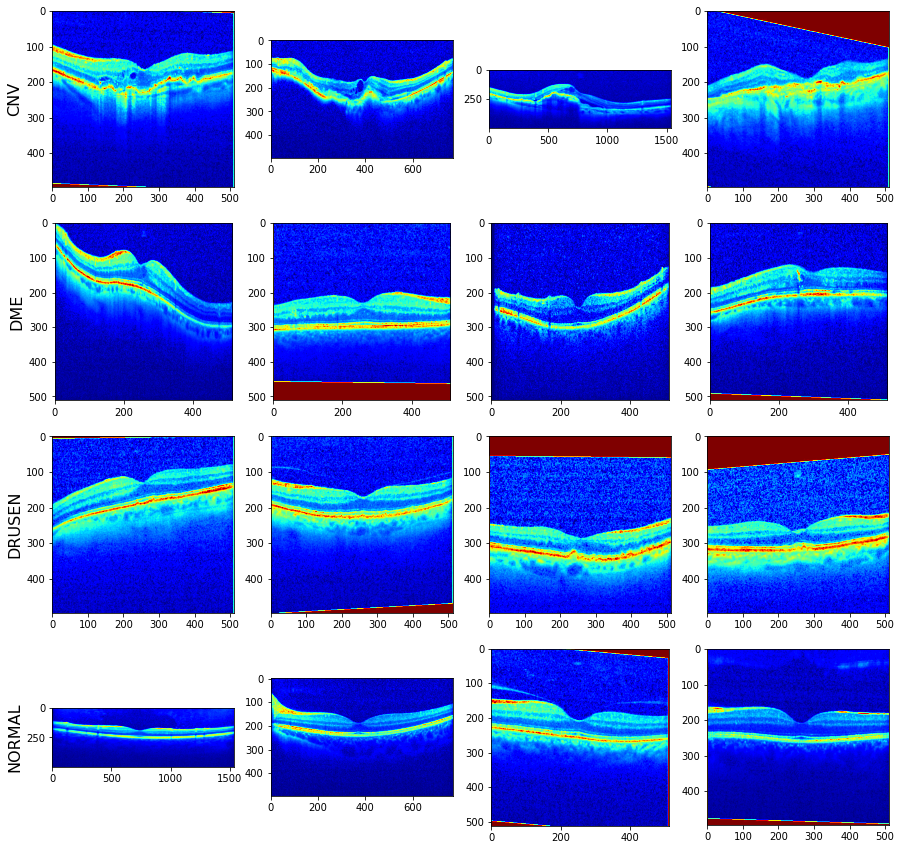

In [11]:
cnv_examples = glob.glob(dataset_path + 'CNV/*')
dme_examples = glob.glob(dataset_path + 'DME/*')
drusen_examples = glob.glob(dataset_path + 'DRUSEN/*')
normal_examples = glob.glob(dataset_path + 'NORMAL/*')

examples = cnv_examples[:4] + dme_examples[:4] + drusen_examples[:4] + normal_examples[:4]

fig=plt.figure(figsize=(15, 15))
columns = 4
rows = 4
for i in range(columns*rows):
    img = plt.imread(examples[i])
    ax = fig.add_subplot(rows, columns, i+1)
    if i%4==0:
        plt.ylabel(classes[int(i/4)], fontsize=16)
    plt.imshow(img, cmap='jet')
plt.show()      

### Verificação da distribuição das classes no dataset --> O dataset está desbalanceado!

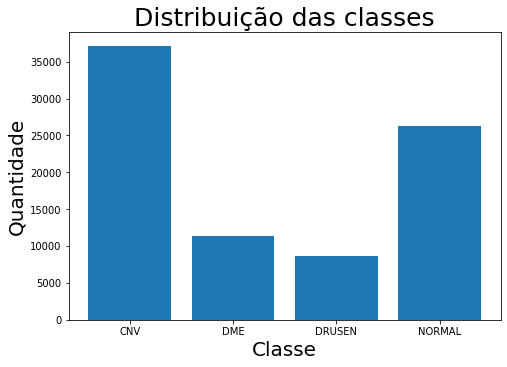

In [12]:
total_cnv_samples = len(glob.glob(dataset_path + 'CNV/*'))
total_dme_samples = len(glob.glob(dataset_path + 'DME/*'))
total_drusen_samples = len(glob.glob(dataset_path + 'DRUSEN/*'))
total_normal_samples = len(glob.glob(dataset_path + 'NORMAL/*'))

sample_distribution = [total_cnv_samples, total_dme_samples, total_drusen_samples, total_normal_samples]

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(classes, sample_distribution)
plt.xlabel("Classe", fontsize=20)
plt.ylabel("Quantidade", fontsize=20)
#fig.set_size_inches( 25, 8)
plt.title("Distribuição das classes", fontsize=25) 
plt.show();

### Separar base em treino, teste e validação

##### As imagens nos diretórios train / val / test originais estavam repetidas, precisamos fazer uma nova separação

In [13]:
# Criar novos diretórios train / val / test (One time use)

val_ratio = 0.15
test_ratio = 0.05

for cls in classes:
  os.makedirs(dataset_path +'train/' + cls)
  os.makedirs(dataset_path +'val/' + cls)
  os.makedirs(dataset_path +'test/' + cls)

  # Creating partitions of the data after shuffeling
  src = dataset_path + cls # Folder to copy images from

  allFileNames = os.listdir(src)
  np.random.shuffle(allFileNames)
  train_FileNames, val_FileNames, test_FileNames = np.split(np.array(allFileNames),
                                                          [int(len(allFileNames)* (1 - (val_ratio + test_ratio))), 
                                                           int(len(allFileNames)* (1 - test_ratio))])


  train_FileNames = [src+'/'+ name for name in train_FileNames.tolist()]
  val_FileNames = [src+'/' + name for name in val_FileNames.tolist()]
  test_FileNames = [src+'/' + name for name in test_FileNames.tolist()]


  print('Total images '+ cls + ':', len(allFileNames))
  print('Training '+ cls + ':', len(train_FileNames))
  print('Validation '+ cls + ':', len(val_FileNames))
  print('Testing '+ cls + ':', len(test_FileNames))
  
  # Copy-pasting images
  
  for name in train_FileNames:
    shutil.copy(name, dataset_path +'train/' + cls)

  for name in val_FileNames:
    shutil.copy(name, dataset_path +'val/' + cls)

  for name in test_FileNames:
    shutil.copy(name, dataset_path +'test/' + cls)                                              

Total images CNV: 37205
Training CNV: 29764
Validation CNV: 5580
Testing CNV: 1861
Total images DME: 11348
Training DME: 9078
Validation DME: 1702
Testing DME: 568
Total images DRUSEN: 8616
Training DRUSEN: 6892
Validation DRUSEN: 1293
Testing DRUSEN: 431
Total images NORMAL: 26315
Training NORMAL: 21052
Validation NORMAL: 3947
Testing NORMAL: 1316


## Data Augmentation

In [14]:
batchSize = 64
init_lr = 1e-3
epochs = 10
num_classes = len(classes)
num_classes

4

In [15]:
trainDataDir = '/content/OCT2017 /train/train'
validationDataDir = '/content/OCT2017 /train/val'
testDataDir = '/content/OCT2017 /train/test'

In [16]:
trainDataGen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=9,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2
)

validationDataGen = ImageDataGenerator(
    rescale=1./255
)

In [17]:
trainGenerator = trainDataGen.flow_from_directory(
    trainDataDir,
    target_size=(299, 299),
    batch_size=batchSize,
    class_mode='categorical',
)

validationGenerator = validationDataGen.flow_from_directory(
    validationDataDir,
    target_size=(299, 299),
    batch_size=batchSize,
    class_mode='categorical',
)

Found 66786 images belonging to 4 classes.
Found 12522 images belonging to 4 classes.


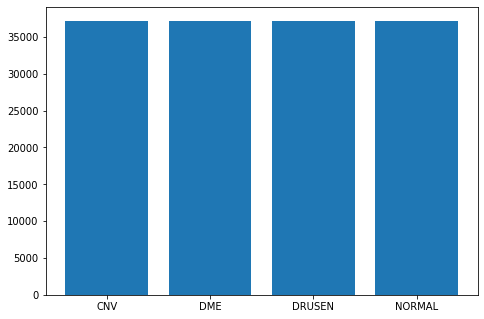

In [19]:
# Balanceamento do dataset - não aumenta as amostras, mas atribui pesos a cada classe para evitar qualquer viés por meio de dados não balanceados (class_weights), os pesos são passados para o model.fit

counter = Counter(trainGenerator.classes)                         
max_val = float(max(counter.values()))  
class_weights = {class_id : max_val/num_images for class_id, num_images in counter.items()}                     

weights = np.fromiter(class_weights.values(), dtype=float)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(classes, sample_distribution*weights) # Distribuição das classes com o ajuste dos pesos (class_weights)
plt.show()


## Construção do modelo utilizando Xception

##### Modelo Xception pré-treinado

In [20]:
# Carregar a rede VGG16 certificando-se de que as camadas principais Full Connected (FC) sejam deixadas de fora

baseModel = Xception(include_top=False, weights="imagenet", input_shape=(299,299,3))

# Congela todas as camadas do modelo para que * não * sejam atualizadas durante o primeiro processo de treinamento
for layer in baseModel.layers:
    layer.trainable = False

baseModel.summary()

83689472/83683744 [==============================] - 0s 0us/step
Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
__________________________

In [25]:
# Construir as camadas Full Connected (FC) "top" do modelo, que substituirão a base da VGG16

headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
headModel = Flatten(name="flatten")(headModel)
#headModel = Dense(64, activation="relu")(headModel)
#headModel = Dropout(0.5)(headModel)
headModel = Dense(num_classes, activation="softmax")(headModel)

# Construir o modelo CNN
model = Model(inputs=baseModel.input, outputs=headModel)

# Compilar o modelo
#opt = SGD(lr=init_lr, decay=init_lr / epochs, momentum=0.9, nesterov=True)
opt = Adam(lr = init_lr, decay= init_lr/epochs)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["categorical_accuracy"])

model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
____________________________________________________________________________________________

### Treinamento do modelo

In [26]:
# Callbacks
es = EarlyStopping(patience=5,monitor="val_loss", mode='auto', restore_best_weights=True)
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5)
mc = ModelCheckpoint(filepath='bestV.h5', save_best_only=True)
csv_logger = CSVLogger('trainingV.log', separator=",", append=False)

In [ ]:
stepsValidation = validationGenerator.samples // batchSize
stepsTraining = trainGenerator.samples // batchSize

history = model.fit(trainGenerator,
    steps_per_epoch = stepsTraining,
    epochs=epochs,
    validation_data = validationGenerator,
    validation_steps = stepsValidation,
    class_weight=class_weights,
    callbacks=[es,rlr,mc,csv_logger]
)

Epoch 1/10
1043/1043 [==============================] - 1621s 2s/step - loss: 1.4424 - categorical_accuracy: 0.6907 - val_loss: 0.5061 - val_categorical_accuracy: 0.8103
Epoch 2/10
1043/1043 [==============================] - 1618s 2s/step - loss: 1.0706 - categorical_accuracy: 0.7870 - val_loss: 0.4122 - val_categorical_accuracy: 0.8493
Epoch 3/10
 881/1043 [========================>.....] - ETA: 3:50 - loss: 1.0112 - categorical_accuracy: 0.8020

### Avaliação do Modelo

In [1]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

num_epochs = range(len(acc))

plt.figure(figsize=(7,7))

plt.plot(num_epochs, acc, 'r', label='Training accuracy')
plt.plot(num_epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure(figsize=(7,7))

plt.plot(num_epochs, loss, 'r', label='Training Loss')
plt.plot(num_epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()
plt.show();

NameError: ignored

### Avaliação do modelo com a base de teste

In [ ]:
test_images_path = glob.glob(testDataDir + '/*/*.jpeg')
x_test = []
y_test = []
for i in range(len(test_images_path)):
    img = cv2.imread(test_images_path[i])
    img = cv2.resize(img, (150,150))
    img = np.array(img/255.0)
    x_test.append(img)
    if 'CNV' in test_images_path[i]:
        y_test.append(0)
    elif 'DME' in test_images_path[i]:
        y_test.append(1)
    elif 'DRUSEN' in test_images_path[i]:
        y_test.append(2)
    elif 'NORMAL' in test_images_path[i]:
        y_test.append(3)
y_test = np.array(y_test)
x_test = np.array(x_test)
print(x_test.shape, y_test.shape)

In [ ]:
y_test_cat = tf.keras.utils.to_categorical(y_test)
loss_and_metrics = model.evaluate(x_test, y_test_cat)

y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred,axis=1)

labels = ('CNV', 'DME', 'DRUSEN', 'NORMAL')

y_actu = pd.Series(y_test, name='Actual')
y_pred = pd.Series(y_pred, name='Predicted')
df_confusion = pd.crosstab(y_actu, y_pred)

df_conf_norm = df_confusion / df_confusion.sum(axis=1)
print(df_confusion)
print(df_conf_norm)

plt.figure(figsize=(20, 20))
plt.matshow(df_confusion, cmap=plt.get_cmap('Blues'), fignum=1)  # imshow
plt.colorbar()
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels,fontsize=16, rotation=60)
plt.yticks(tick_marks, labels, fontsize=16)
thresh = 0.6

for i in range(n_classes):
    for j in range(n_classes):
        plt.text(i, j, "{:0.2f}%".format(df_conf_norm[i][j] * 100),
                 horizontalalignment='center',
                 color='white' if df_conf_norm[i][j] > thresh else 'black',
                 fontsize = 16)

plt.tight_layout()
plt.ylabel(df_confusion.index.name, fontsize=16)
plt.xlabel(df_confusion.columns.name,fontsize=16)
plt.show()

In [ ]:
y_test_cat = tf.keras.utils.to_categorical(y_test)
loss_and_metrics = modelV.evaluate(x_test, y_test_cat)

y_pred = modelX.predict(x_test)
y_pred = np.argmax(y_pred,axis=1)

labels = ('CNV', 'DME', 'DRUSEN', 'NORMAL')

y_actu = pd.Series(y_test, name='Actual')
y_pred = pd.Series(y_pred, name='Predicted')
df_confusion = pd.crosstab(y_actu, y_pred)

df_conf_norm = df_confusion / df_confusion.sum(axis=1)
print(df_confusion)
print(df_conf_norm)

for i in range(n_classes):
    for j in range(n_classes):
        plt.text(i, j, "{:0.2f}%".format(df_conf_norm[i][j] * 100),
                 horizontalalignment='center',
                 color='white' if df_conf_norm[i][j] > thresh else 'black',
                 fontsize = 16)

plt.tight_layout()
plt.ylabel(df_confusion.index.name, fontsize=16)
plt.xlabel(df_confusion.columns.name,fontsize=16)
plt.show()